# Python implementation of MRL99 algorithm for finding approximate quantiles on streaming data.

## Said Kamalov, s.kamalov@innopolis.university, Telegram: @SaidKbshsb

February 2023



## Simulation of finding quantile on streaming data with numpy.

In [37]:
import numpy as np


class NumpyQuantileAlgorithm(BasicQuantileAlgorithm):
    """
    Example of quantile algorithm

    This algorithm implementation is
    based on the numpy.quantile.
    """

    def __init__(self):
        """
        Initializer of the class.

        It initializes self.data with empty list
        """
        self.data = []

    def add_item(self, item):
        """
        Adds an item to the existing data
        """
        self.data.append(item)

    def add_multiple_items(self, items):
        """
        Adds multiple items to the existing data
        """
        self.data += items

    def compute_quantile(self, q) -> float:
        """
        Compute the q-th quantile

        :param q: Quantile to compute, which must be between 0 and 1 inclusive
        :return: q-th quantile
        """
        return np.quantile(self.data, q)

    # NOTE: Here, for multi_compute we
    # can just call the same function
    # compute_quantile, because it could
    # take a vector of multiple quantiles.
    # This is more efficient, than basic
    # function call, because of the
    # vectorized implementation.
    def multi_compute(self, qs) -> List[float]:
        """
        Compute multiple q-th quantiles

        :param qs: list of quantiles to compute,
            all should be between 0 and 1 inclusive
        :return: list of computed quantiles
        """
        return list(self.compute_quantile(qs))

## MRL99 Implementation:

In [38]:
import numpy as np
import math
from sys import getsizeof
from pympler import asizeof

INF = 1e14

In [39]:
class Stream:
    """
     A class that simulates streaming data.

    Attributes
    ----------
    n : int
        length of data stream
    arr : List-Like
        data for streaming

    Methods
    -------
    get_with_sampling(n_smpl, smpl_rate=1)
        return n_smpl samples from data stream
        with sampling rate = smpl_rate.

    is_ended()
        return True if data stream is over.
    """

    def __init__(self, n, arr=None):
        self.n = n
        self.arr = arr

    def get_with_sampling(self, n_smpl: int, smpl_rate: int = 1):
        """
        return n_smpl samples from data stream
        with sampling rate = smpl_rate.

        Parameters
        ----------
        n_smpl : int
            number of samples to return
        smpl_rate : int
            sampling rate

        Yields
        ------
        a sample from data stream of size smpl_rate

        """
        i = 0
        while self.n > 0 and i < n_smpl:
            ptr = min(smpl_rate, self.n)
            sample = self.arr[:ptr]
            self.arr = self.arr[ptr:]
            i += 1
            self.n -= smpl_rate
            yield sample

    def is_ended(self):
        """
        return True if stream is over.
        """
        if self.n <= 0:
            return True
        else:
            return False

In [40]:
class Buffer:
    """
    A class that represents buffer for MRL99.

    Attributes
    ----------
    k : int
        capacity of the buffer
    weight : int
        weight of the buffer
    level : int
        current level of the buffer in tree representation
    load : int
        a value in (0, 1, 2) where:
        0 shows that buffer is empty
        1 shows that buffer is partially full
        2 shows that buffer is full
    data : np.ndarray
        data stored in the buffer
    size : int
        current size of the data inside the buffer

    Methods
    -------
    add(val)
        add value to the buffer with load control.

    clear()
        clear the buffer and reset parameters to initial state.
    """

    def __init__(self, k: int, weight: int = 1, level: int = 0, load: int = 0):
        self.data = np.zeros(k)
        self.weight = weight
        self.level = level
        self.load = load  # 0-empty, 1-partialy full, 2-full
        self.size = 0

    def add(self, val: float):
        """
        add value to the buffer with load control.

        Parameters
        ----------
        val : float
            value to add in buffer

        Returns
        -------
        None
        """
        if self.size == 0:
            self.load = 1
        self.data[self.size] = val
        self.size += 1
        if self.size == self.data.size:
            self.load = 2

    def clear(self):
        """
        clear the buffer and reset parameters to initial state.
        """
        self.load = 0
        self.size = 0
        self.level = 0
        self.weight = 1

In [41]:
class MRL99:
    """
    A class is the impementation of MRL99 algorithm for finding approximate quatile on streaming data.
    The algorithm is based on 3 main operations:
        New operation
        Collapse operation
        Output operation
    To get the quantile user should create and pass obj: Stream, and specify the quantile=q 0<q<1.

    Attributes
    ----------
    b : int
        number of buffers
    k : int
        capacity of each buffer
    r : int
        sampling rate
    h : int
        height of the tree after wich algorithm starts dynamicly increase a sample rate
    curr_h : int
        current height of tree representation
    base_lvl : int
        the level of the tree to assign to the buffer in New operation
    buffers : [Buffer]
        buffers for MRL99
    n_empty_buffers : int
        number of empty buffers
    min_lvl : int
        minimum level among full buffers
    mem: int
        memeory occupied by buffers in bytes

    Methods
    -------
    new(buffer)
        implementation of New operation
    collapse(buffers)
        implementation of Collapse operation
    output(q)
        implementation of Output operation
    get_quantile(stream, q)
        run the MRL99 and get the q-quantile
    find_min_(buffers, positions)
        find miminum element from buffers
    """

    def __init__(self, b: int, k: int, r: int, h: int):
        self.b = b  # number of buffers.
        self.k = k  # capacity of the buffer.
        self.r = r  # sampling rate.
        self.h = h

        # we subtract 1 as we start changing r and base level when min_lvl = h.
        self.curr_h = self.h - 1

        self.base_lvl = self.r - 1  # according to collapse policy.
        self.buffers = [Buffer(self.k) for i in range(b)]
        self.n_empty_buffers = self.b
        self.min_lvl = self.base_lvl

        self.mem = 0

    def new(self, buffer):
        """
        Implementation of New operation.
        new takes as input an empty buffer. It is invoked only
        if there is an empty buffer and at least one outstanding
        element in the input sequence. The operation simply
        populates the buffer by choosing a single random
        element from a block of size r, k such blocks.
        The buffer assigned with weigth = r, level = base_lvl.
        Also minimum level among full buffers is updated.

        Parameters
        ----------
        buffer : Buffer
            an empty buffer

        Returns
        -------
        None

        """
        # populating buffer
        samples = self.stream.get_with_sampling(self.k, self.r)
        for sample in samples:
            buffer.add(np.random.choice(sample))

        # if stream is over but buffer is not full
        # populate it with +- inf
        sign = 1
        while buffer.load != 2:
            buffer.add(sign * INF)
            sign = -sign

        # update buffer's parameters
        buffer.weight = self.r
        buffer.data = np.sort(buffer.data)
        buffer.level = self.base_lvl
        self.n_empty_buffers -= 1

        # update minimum level
        if buffer.level < self.min_lvl:
            self.min_lvl = buffer.level

        # record the memory consumption
        if asizeof.asizeof(self.buffers) > self.mem:
            self.mem = asizeof.asizeof(self.buffers)

    def collapse(self, buffers):
        """
        collapse takes c>=2 full buffers, denoted by
        X1, X2, ... , Xc and outputs a buffer, Y, each of size k.
        In the end, all but one buffer is marked empty.
        The output Y is stored in the buffer that is marked full.
        The weight of the output buffer w(Y) is the sum
        of weights of buffers X1, X2, ... , Xc.
        Consider making w(Xi) (weigth of Xi) copies of each element in Xi
        and sorting all the input buffers together,
        taking into account the multiplecopies.
        The e1ements in Y are simply k equally spaced
        elements in this (sorted) sequence. If w(Y) is odd,
        these k elements are in positions j*w(Y) + (w(Y)+1)/2,
        for j = 0,1 ... ,k - 1. If w(Y) is even,
        these k elements are in positions j*w(Y) + w(Y)/2,
        for j = 0,1 ... ,k - 1.

        Parameters
        ----------
        buffers : [Buffer]
            list of full buffers with minimum level.

        Returns
        -------
        None
        """
        # calculate weight of the output buffer
        weight_sum = sum([buff.weight for buff in buffers])
        # offset to get elems of output buffer
        offset = int((weight_sum + (weight_sum % 2)) / 2)
        new_data = np.zeros(self.k)

        # get elements for output buffer
        positions = [0 for i in range(len(buffers))]
        for i in range(self.k):
            cursor = weight_sum
            if i == 0:
                cursor = offset
            while cursor > 0:
                elem, reps, positions = self.find_min_(buffers, positions)
                cursor -= reps
                if cursor <= 0:
                    new_data[i] = elem

        # reset all but one buffer
        for buff in buffers[1:]:
            buff.clear()

        # fill buffer Y
        buffers[0].data = new_data
        buffers[0].load = 2

        # According to collapse policy:
        buffers[0].weight = weight_sum
        buffers[0].level = self.min_lvl + 1
        if len(buffers) == self.b and self.min_lvl > self.curr_h:
            self.r *= 2
            self.base_lvl += 1
            self.curr_h += 1

        # As all buffers with level min_lvl now empty,
        # min_lvl will encrease by 1.
        self.min_lvl += 1

        # all but one passed buffers are empty now.
        self.n_empty_buffers += len(buffers) - 1

        # record the memory consumption
        if asizeof.asizeof(self.buffers) > self.mem:
            self.mem = asizeof.asizeof(self.buffers)

    def output(self, q):
        """
        output is invoked whenever a current estimate
        of the quantiles is desired or if the input stream
        runs dry.

        Parameters
        ----------
        q : float
            order of quantile ex: 0.5 (median)

        Returns
        -------
        elem : float
            q-quantile
        """
        # get all full buffers
        buffers = []
        for buff in self.buffers:
            if buff.load == 2:
                buffers.append(buff)

        # calculate position of the quantile.
        q_ind = math.ceil(q * sum([self.k * buff.weight for buff in buffers]))

        # find quantile in merged and sorted buffers
        positions = [0 for i in range(len(buffers))]
        while q_ind > 0:
            elem, reps, positions = self.find_min_(buffers, positions)
            q_ind -= reps
            if q_ind <= 0:
                return elem

    def get_quantile(self, stream, q=0.5):
        """
        Run MRL99 to get the quantile

        Parameters
        ----------
        stream : Stream
            data stream
        q : float
            order of quantile

        Returns
        -------
        q-qunatile
        """
        self.stream = stream
        while not self.stream.is_ended():
            empty_buffers = [buff for buff in self.buffers if buff.load == 0]
            if len(empty_buffers) >= 1:
                for buff in empty_buffers:
                    self.new(buff)
                    if self.stream.is_ended():
                        break
            else:
                full_buffs = []
                for buff in self.buffers:
                    if buff.load == 2 and buff.level == self.min_lvl:
                        full_buffs.append(buff)
                if len(full_buffs) > 1:
                    self.collapse(full_buffs)
                else:
                    full_buffs[0].level += 1
                    self.min_lvl += 1
        full_buffs = []
        for buff in self.buffers:
            if buff.load == 2 and buff.level == self.min_lvl:
                full_buffs.append(buff)
        if len(full_buffs) > 1:
            self.collapse(full_buffs)
        return self.output(q)

    def find_min_(self, buffers, positions):
        """
        Find minimum element in merged sequence of buffer.
        Positions show from which element each buffer is merged.

        Parameters
        ----------
        buffers : [Buffer]
            list of buffers
        positions: [int]
            list of indexes for starting elementes to merge for each buffer

        Returns
        -------
        min : float
            minimum element
        w : int
            weight of buffer where min came from
        positions : [int]
            updated positions
        """
        min = INF
        w = -1
        buff_ind = -1
        for i, buff in enumerate(buffers):
            if buff.data[positions[i]] < min:
                min = buff.data[positions[i]]
                w = buff.weight
                buff_ind = i
        if positions[buff_ind] < self.k - 1:
            positions[buff_ind] += 1
        return min, w, positions

## Report about MRL99 algorithm for finding quantiles on streaming data

**MRL99**[1] is an efficient algorithm for approximate quantile finding. MRL99 is based on the framework presented in MRL98 [2], but the key difference is that MRL99 does not require knowledge of input data size in advance. Problem that can be solved by this algorithm can be formulated as follows:

Given $\phi$, $\epsilon$ and $\delta$ algorithm computes, with probability at least $1-\delta$, an $\epsilon$-approximate $\phi$-quantile of input sequence using as little main memory as possible, without knowing the length of sequence in advance.

**General idea:**
The algorithm is parametrized by three integers: b - *number of buffers*, k - *capacity of the buffer*, h - *height of the tree after wich algorithm starts dynamicly increase a sample rate (r)*. Each buffer has *weight* and *hieght*. Algorithm operates with buffers with three main operations:
<ul>
<li>New operation</li>    
<li>Collapse operation</li>
<li>Output operation</li>
</ul>

Let me briefly describe each operation:

**New operation**:
While there is at least one outstanding element in the input space, we populate buffers by choosing one random element from each of k blocks of size r.

**Collapse operation**:
If all buffers are full or data stream has ended, we *collapse* full buffers with minimum weight. Collpase process itself is explicitly described in [1].

**Output**
Output is performed exactly ones, just before termination. It creates a finall sequence from full buffers and return approximated quantile.

In [42]:
import matplotlib.pyplot as plt
import time

### Time coparison

In [10]:
np_time = []
mrl99_time = []
N = [1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
q = 0.5
b = 7
k = 9121
r = 1
h = 11
np_q = NumpyQuantileAlgorithm()
for n in N:
    mrl99 = MRL99(b, k, r, h)
    a = np.random.rand(int(n))
    stream = Stream(len(a), a)
    np_q.data = a

    st_t = time.time()
    mrl99.get_quantile(stream, q)
    end_t = time.time()
    mrl99_time.append(end_t - st_t)

    st_t = time.time()
    np_q.compute_quantile(q)
    end_t = time.time()
    np_time.append(end_t - st_t)
print(*mrl99_time)
print(*np_time)

0.007750511169433594 0.012777566909790039 0.08659243583679199 0.8387186527252197 8.61067509651184 86.43507671356201
0.0006504058837890625 0.00020766258239746094 0.0003731250762939453 0.0016293525695800781 0.013840436935424805 0.1904287338256836


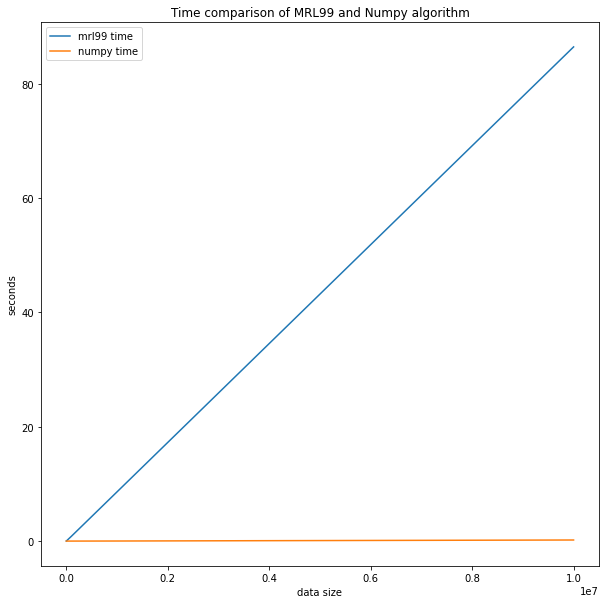

In [11]:
plt.figure(figsize=(10, 10))
plt.plot(N, mrl99_time, label="mrl99 time")
plt.plot(N, np_time, label="numpy time")
plt.ylabel("seconds")
plt.xlabel("data size")
plt.legend()
plt.title("Time comparison of MRL99 and Numpy algorithm")
plt.show()

We can see that time consumption of MRL99 grows linearly with input data size. But it is important to consider that in real cases data stream has a delay that will to some extent negotiate the time consumption of MRL99. 


### Space comparison

In [13]:
mrl99_mem = []
np_mem = []
N = [1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
q = 0.5
b = 7
k = 9121
r = 1
h = 11
np_q = NumpyQuantileAlgorithm()
for n in N:
    mrl99 = MRL99(b, k, r, h)
    a = np.random.rand(int(n))
    stream = Stream(len(a), a)
    np_q.data = a

    mrl99.get_quantile(stream, q)
    np_q.compute_quantile(q)

    mrl99_mem.append(mrl99.mem)
    np_mem.append(asizeof.asizeof(np_q))
print(*mrl99_mem)
print(*np_mem)

513160 513160 513192 513352 513544 513608
1136 8336 80336 800336 8000336 80000336


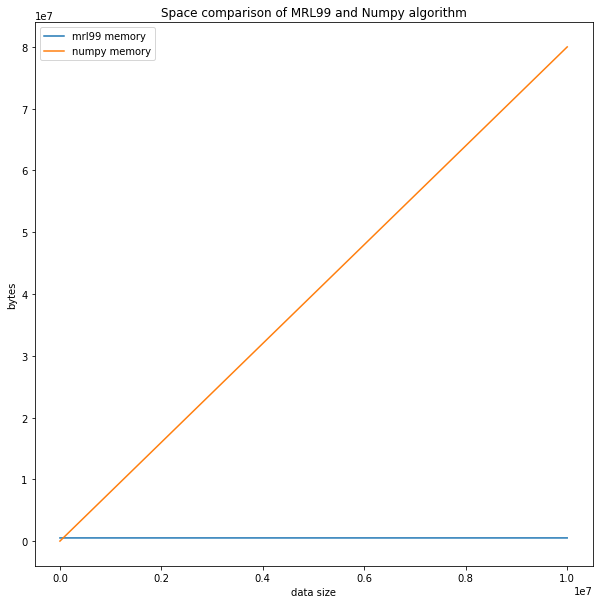

In [14]:
plt.figure(figsize=(10, 10))
plt.plot(N, mrl99_mem, label="mrl99 memory")
plt.plot(N, np_mem, label="numpy memory")
plt.ylabel("bytes")
plt.xlabel("data size")
plt.legend()
plt.title("Space comparison of MRL99 and Numpy algorithm")
plt.show()

We can see that MRL99 consumes constant amount of memory. This is extremely useful when someone dealing with enormously large data streams.

## Test

1. Take `normal` distribution. Show, that with increase in sample size, quantiles calculated with your algorithms are become very close to the `inverse cdf` of the distribution.  - **Theoretical assumtion**.

2. Perform the same experiment with exponential distribution.

In [15]:
## your experiments here
from scipy import stats

N = [1e4, 1e5, 1e6, 1e7]
b = 7
k = 9121
r = 1
h = 11

normal_results = []

qs = np.linspace(0.1, 0.9, 8)
normal_ppf = stats.norm.ppf(qs)
exp_ppf = stats.expon.ppf(qs)
for n in N:
    n_res = []
    for q in qs:
        mrl99 = MRL99(b, k, r, h)
        stream = Stream(
            n=int(n),
            arr=stats.norm.rvs(size=int(n)),
        )
        mrl99_q = mrl99.get_quantile(stream, q)
        print(
            f"{q}-quantile of data size={n}={mrl99_q},",
            f"normal ppf: {stats.norm.ppf(q)}",
        )
        n_res.append(mrl99_q)
    normal_results.append(n_res)
print(normal_results)
print(normal_ppf)

0.1-quantile of data size=10000.0=-100000000000000.0, normal ppf: -1.2815515655446004
0.2142857142857143-quantile of data size=10000.0=-100000000000000.0, normal ppf: -0.7916386077433746
0.3285714285714286-quantile of data size=10000.0=-0.8694807295355684, normal ppf: -0.4438613119262475
0.44285714285714284-quantile of data size=10000.0=-0.26308557056246484, normal ppf: -0.14372923370582416
0.5571428571428572-quantile of data size=10000.0=0.26168300781128184, normal ppf: 0.14372923370582416
0.6714285714285715-quantile of data size=10000.0=0.9084890449988144, normal ppf: 0.4438613119262478
0.7857142857142857-quantile of data size=10000.0=3.81664905667455, normal ppf: 0.7916386077433746
0.9-quantile of data size=10000.0=3.8644887641737298, normal ppf: 1.2815515655446004
0.1-quantile of data size=100000.0=-1.2879849420439515, normal ppf: -1.2815515655446004
0.2142857142857143-quantile of data size=100000.0=-0.7933682169923303, normal ppf: -0.7916386077433746
0.3285714285714286-quantile of

<Figure size 720x720 with 0 Axes>

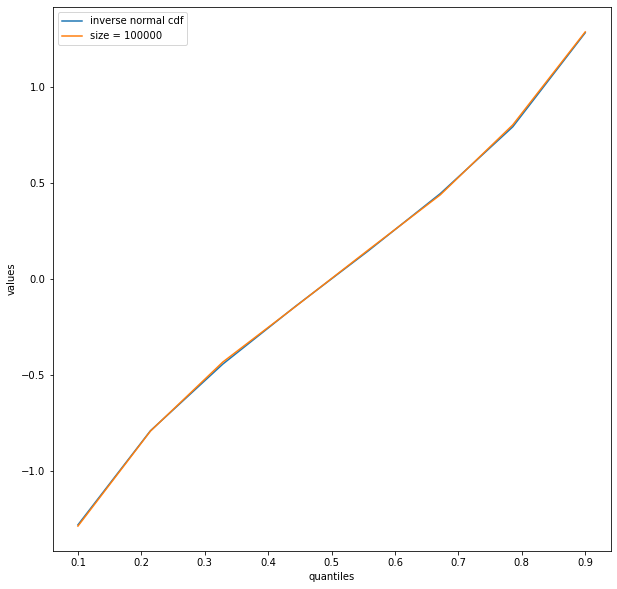

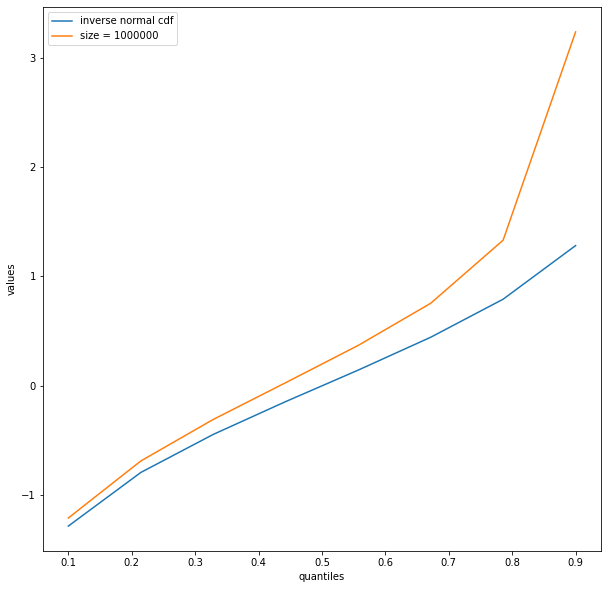

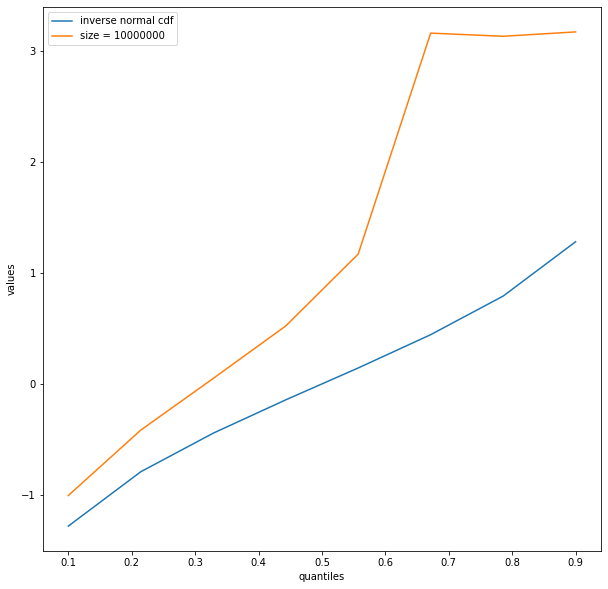

In [27]:
for i, n in enumerate(N):
    if i >= 1:
        plt.figure(figsize=(10, 10))
        plt.plot(qs, normal_ppf, label="inverse normal cdf")
        plt.plot(qs, normal_results[i], label=f"size = {int(n)}")
        plt.ylabel("values")
        plt.xlabel("quantiles")
        plt.legend()
        plt.show()

In [49]:
N = [1e4, 1e5, 1e6, 1e7]
b = 7
k = 9121
r = 1
h = 11

expon_results = []

qs = np.linspace(0.1, 0.9, 8)
exp_ppf = stats.expon.ppf(qs)
for n in N:
    n_res = []
    for q in qs:
        mrl99 = MRL99(b, k, r, h)
        stream = Stream(
            n=int(n),
            arr=stats.expon.rvs(size=int(n)),
        )
        mrl99_q = mrl99.get_quantile(stream, q)
        print(
            f"{q}-quantile of data size={n}={mrl99_q},",
            f"expon ppf: {stats.expon.ppf(q)}",
        )
        n_res.append(mrl99_q)
    expon_results.append(n_res)
print(expon_results)
print(exp_ppf)

0.1-quantile of data size=10000.0=-100000000000000.0, expon ppf: 0.10536051565782631
0.2142857142857143-quantile of data size=10000.0=-100000000000000.0, expon ppf: 0.2411620568168881
0.3285714285714286-quantile of data size=10000.0=0.2091209651275875, expon ppf: 0.3983476403393005
0.44285714285714284-quantile of data size=10000.0=0.49998106249704544, expon ppf: 0.5849335959197125
0.5571428571428572-quantile of data size=10000.0=0.9356189836332397, expon ppf: 0.8145080375642128
0.6714285714285715-quantile of data size=10000.0=1.6888787618762475, expon ppf: 1.1130010261202095
0.7857142857142857-quantile of data size=10000.0=9.255406205950251, expon ppf: 1.5404450409471488
0.9-quantile of data size=10000.0=9.878651603361464, expon ppf: 2.302585092994046
0.1-quantile of data size=100000.0=0.10298948962466534, expon ppf: 0.10536051565782631
0.2142857142857143-quantile of data size=100000.0=0.23916862582955406, expon ppf: 0.2411620568168881
0.3285714285714286-quantile of data size=100000.0=

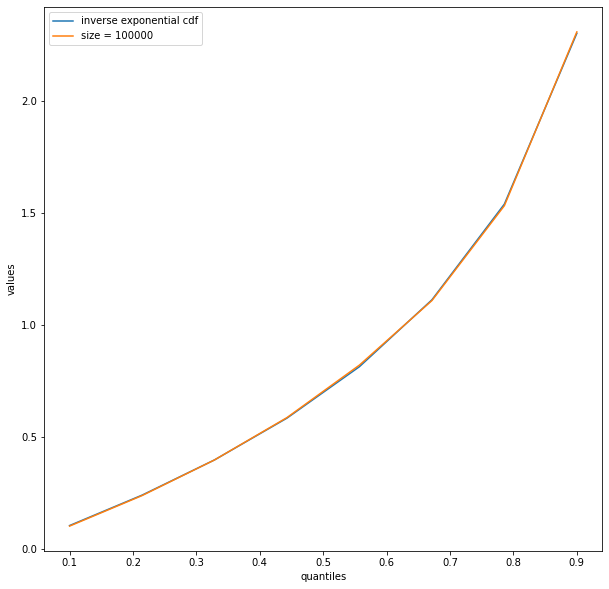

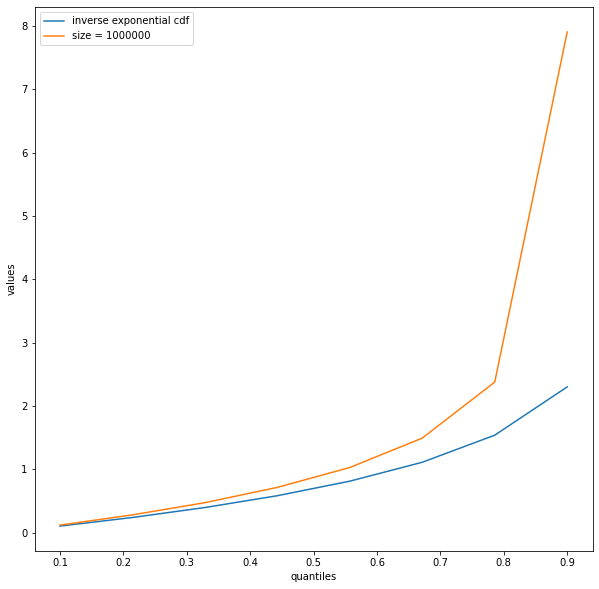

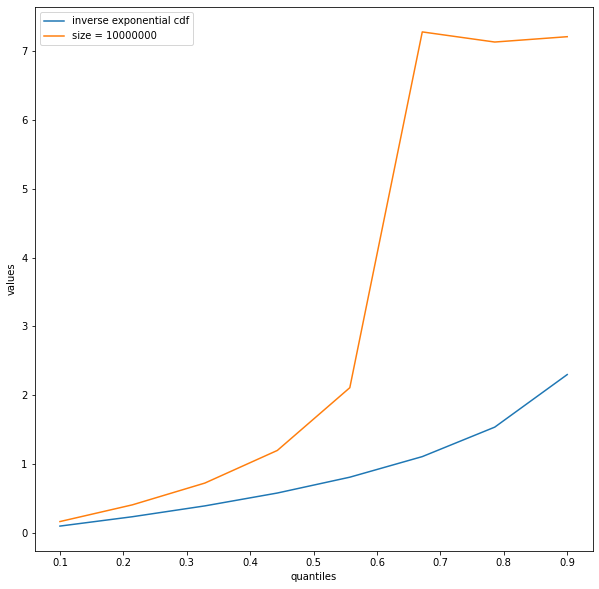

In [50]:
for i, n in enumerate(N):
    if i >= 1:
        plt.figure(figsize=(10, 10))
        plt.plot(qs, exp_ppf, label="inverse exponential cdf")
        plt.plot(qs, expon_results[i], label=f"size = {int(n)}")
        plt.ylabel("values")
        plt.xlabel("quantiles")
        plt.legend()
        plt.show()

## Conclusion on tests:

It is interesting to notice that MRL99 results are closest to inverse cdf of normal and exponential distributions when input data size = $10^5$. And then, with grow of input data size, difference between values of inverse cdf and MRL99 is also increasing. These results contradict with the theoretical assumption: "that with increase in sample size, quantiles calculated with your algorithms are become very close to the `inverse cdf` of the distribution." 

This situation occures because we did not decrease $\epsilon$ while input data size was increasing. Therefore we did not change parameters of MRl99 b, k, h. Consequently, as b and k did not change, our samples for estimating quantile did not grow unlike input data. One can agree that it is a reasong for growing difference between values of inverse cdf and MRL99 results.

We can rerun test with normal distribution and changing parameters to decrease $\epsilon$. This will lead to better approximation, but will be useless in terms of memory efficiency.

In [51]:
N = [1e5, 1e6, 1e7]
params1 = {"b": 7, "k": 9121, "r": 1, "h": 11}
params2 = {"b": 9, "k": 102599, "r": 1, "h": 13}
params3 = {"b": 10, "k": 1189647, "r": 1, "h": 16}
params = [params1, params2, params3]

normal_results = []

qs = np.linspace(0.1, 0.9, 8)
normal_ppf = stats.norm.ppf(qs)
exp_ppf = stats.expon.ppf(qs)
for i, n in enumerate(N):
    n_res = []
    for q in qs:
        mrl99 = MRL99(**params[i])
        stream = Stream(
            n=int(n),
            arr=stats.norm.rvs(size=int(n)),
        )
        mrl99_q = mrl99.get_quantile(stream, q)
        print(
            f"{q}-quantile of data size={n}={mrl99_q},",
            f"normal ppf: {stats.norm.ppf(q)}",
        )
        n_res.append(mrl99_q)
    normal_results.append(n_res)
print(normal_results)
print(normal_ppf)

0.1-quantile of data size=100000.0=-1.2994131742908777, normal ppf: -1.2815515655446004
0.2142857142857143-quantile of data size=100000.0=-0.799936794563787, normal ppf: -0.7916386077433746
0.3285714285714286-quantile of data size=100000.0=-0.44814406687093494, normal ppf: -0.4438613119262475
0.44285714285714284-quantile of data size=100000.0=-0.14375240488606048, normal ppf: -0.14372923370582416
0.5571428571428572-quantile of data size=100000.0=0.14575922616951803, normal ppf: 0.14372923370582416
0.6714285714285715-quantile of data size=100000.0=0.4517489076417408, normal ppf: 0.4438613119262478
0.7857142857142857-quantile of data size=100000.0=0.7998249506906262, normal ppf: 0.7916386077433746
0.9-quantile of data size=100000.0=1.2848224685958634, normal ppf: 1.2815515655446004
0.1-quantile of data size=1000000.0=-1.3430763631400173, normal ppf: -1.2815515655446004
0.2142857142857143-quantile of data size=1000000.0=-0.8181016224962858, normal ppf: -0.7916386077433746
0.32857142857142

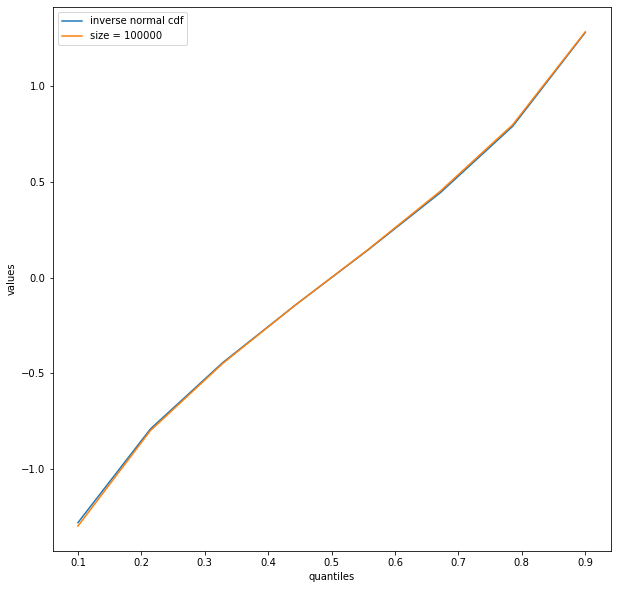

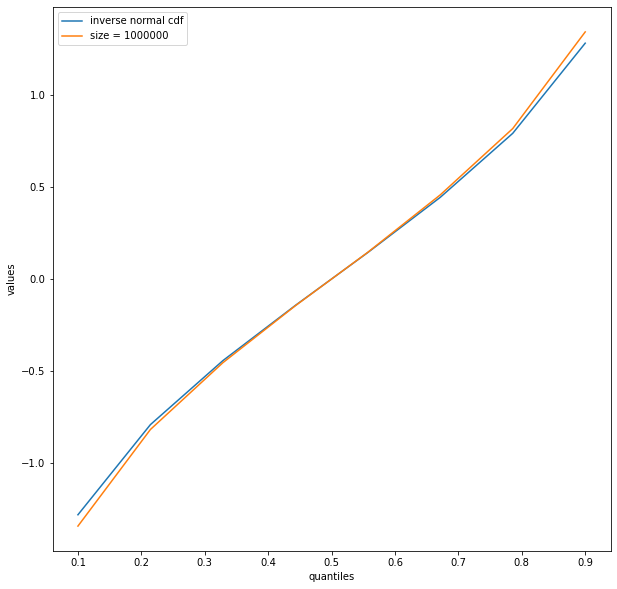

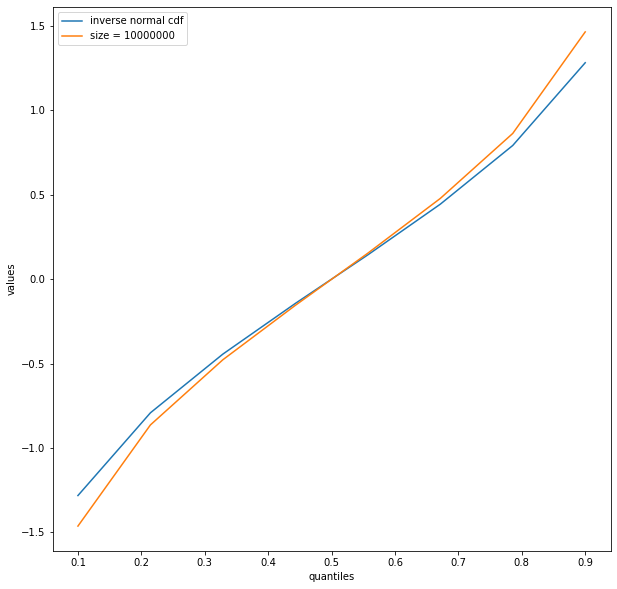

In [53]:
for i, n in enumerate(N):
    plt.figure(figsize=(10, 10))
    plt.plot(qs, normal_ppf, label="inverse normal cdf")
    plt.plot(qs, normal_results[i], label=f"size = {int(n)}")
    plt.ylabel("values")
    plt.xlabel("quantiles")
    plt.legend()
    plt.show()

Perform an experiment that shows the main purpose of the algorithm. 

For example, some algorithms are created especially for time series data, so you should show that your algorithm is working in time series environment properly.

According to [1] MRL99 is usefull to predict quantiles on streaming data. As example, to get some information while working with enormous databases.

My example will simulate data stream through Stream class. However the main purpose of this example is to show that by solving a constrained optimization problem described in [1] one can get parameters which will give good quantile approximation. Moreover, if k*b bytes is much lesser than input data stream size in bytes, MRL99 will be great in terms of memory efficiency. 

In [55]:
params1 = {"b": 7, "k": 9121, "r": 1, "h": 11}
params2 = {"b": 9, "k": 102599, "r": 1, "h": 13}
a = np.random.rand(int(1e7))

time1 = []
time2 = []

qs1 = []
qs2 = []
q_np = []

mem1 = []
mem2 = []
for q in [0.25, 0.5, 0.75]:
    mrl99_1 = MRL99(**params1)
    mrl99_2 = MRL99(**params2)
    stream1 = Stream(len(a), a)
    stream2 = Stream(len(a), a)

    st_t = time.time()
    q1 = mrl99_1.get_quantile(stream1, q)
    end_t = time.time()
    time1.append(end_t - st_t)

    st_t = time.time()
    q2 = mrl99_2.get_quantile(stream2, q)
    end_t = time.time()
    time2.append(end_t - st_t)

    mem1.append(mrl99_1.mem)
    mem2.append(mrl99_2.mem)

    qs1.append(q1)
    qs2.append(q2)
    q_np.append(np.quantile(a, q))

    print(f"finished with {q}-quantile!")

finished with 0.25-quantile!
finished with 0.5-quantile!
finished with 0.75-quantile!


In [57]:
print("Time coparison:")
print("with params1:", time1)
print("with params2:", time2)
print("Memory consumption")
print("with params1:", mem1)
print("with params2:", mem2)
print("size of data stream:", getsizeof(a))
print("Results:")
print("with params1:", qs1)
print("with params2:", qs2)
print("real:", q_np)

Time coparison:
with params1: [89.51136708259583, 89.08607363700867, 88.9275951385498]
with params2: [90.03356766700745, 89.99856615066528, 90.06020975112915]
Memory consumption
with params1: [513608, 513608, 513608]
with params2: [7390584, 7390584, 7390584]
size of data stream: 80000112
Results:
with params1: [0.39375746547890367, 0.7896705524355044, 0.9991216393192631]
with params2: [0.2609593177002051, 0.5249246941729699, 0.7891866233850401]
real: [0.2497717155990003, 0.499722685699617, 0.7499150445267777]


**We can see that MRL99 with parameters b=9 k=102599 h=13 gave us great approximation and took 10 times less memory than the actual size of the data stream with $10^7$ elements.**

References:

[1] - G. S. Manku, S. Rajagopalan, and B. G. Lindsay, “Random sampling
techniques for space efficient online computation of order statistics
of large datasets,” in SIGMOD 1999, Proceedings ACM SIGMOD
International Conference on Management of Data, June 1-3, 1999,
Philadelphia, Pennsylvania, USA, pp. 251–262, 1999.

[2] - G. S. Manku, S. Rajagopalan, and B. G. Lindsay, “Approximate medians
and other quantiles in one pass and with limited memory,” in SIGMOD
1998, Proceedings ACM SIGMOD International Conference on Manage-
ment of Data, June 2-4, 1998, Seattle, Washington, USA, pp. 426–435,
1998.
